In [1]:
# This notebook trains LSTM model on the preprocessed forecasted data

# forecast_features= [
#     "forecast_alberta_internal_load", 
#     "rolling_30day_avg_price", 
#     "solar_generation", 
#     "wind_generation", 
#     "temp_calgary", 
#     "temp_edmonton", 
#     "temp_fortmc", 
#     "ws_calgary",
#     "ws_edmonton", 
#     "ws_fortmc",
#     "datetime_", 
#     "hour_of_day", 
#     "day_of_week", 
#     "day_of_month", 
#     "week_of_month", 
#     "month", 
#     "year", 
#     "is_winter" 
# ]


# NVIDIA-SMI 535.183.01 
# CUDA Version: 10.1
# CUDNN Version: 
    #define CUDNN_MAJOR 7
    #define CUDNN_MINOR 6
    #define CUDNN_PATCHLEVEL 5
# Tensorflow Version: 2.2.0
# Python Version: 3.8.10

#### Library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set pandas to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Suppress pandas performance warnings
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
from datetime import datetime, timedelta
import joblib

In [3]:
# check tf version
print('TensorFlow version:', tf.__version__)

#  Check if TensorFlow can access GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow is using GPU: {gpus}")
else:
    print("No GPU found, using CPU instead.")

TensorFlow version: 2.2.0
TensorFlow is using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-03-20 16:04:33.257090: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-03-20 16:04:33.296073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-20 16:04:33.296328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.189GHz coreCount: 3 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 37.33GiB/s
2025-03-20 16:04:33.296788: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-03-20 16:04:33.299434: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-20 16:04:33.302084: I tensorflow/stream_executor/platform

#### Data Loading

In [4]:
# Load the data
# df2019 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2019/merged_df_2019_cleaned.csv')
df2020 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2020/merged_df_2020_cleaned.csv')
df2021 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2021/merged_df_2021_cleaned.csv')
df2022 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2022/merged_df_2022_cleaned.csv')
df2023 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2023/merged_df_2023_cleaned.csv')
df2024 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2024/merged_df_2024_cleaned.csv')

In [5]:
# Concatenate the data
# df2019
df = pd.concat([df2020, df2021, df2022, df2023, df2024], axis=0, ignore_index=True)

In [6]:
df.shape

(43863, 69)

In [7]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2020-01-01 00:00:00,9467.0,9688.0,30.24,28.79,43.49,0.0,2.2,-0.6,-2.7,875.637983,10.0,11.0,7.0,0,2,1,1,1,2020,1,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
1,2020-01-01 01:00:00,9361.0,9541.0,29.43,28.19,43.49,0.0,1.4,1.1,-4.6,778.695505,7.0,11.0,3.0,1,2,1,1,1,2020,1,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
2,2020-01-01 02:00:00,9286.0,9410.0,29.66,31.19,43.49,0.0,2.5,1.3,-7.0,717.339528,8.0,11.0,6.0,2,2,1,1,1,2020,1,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
3,2020-01-01 03:00:00,9209.0,9328.0,28.19,28.19,43.49,0.0,1.4,0.2,-5.2,691.670863,3.0,11.0,0.0,3,2,1,1,1,2020,1,29.66,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9286.0,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
4,2020-01-01 04:00:00,9195.0,9319.0,31.17,28.19,43.49,0.0,-0.3,0.4,-4.1,553.970998,0.0,11.0,4.0,4,2,1,1,1,2020,1,28.19,29.66,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9209.0,9286.0,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0


In [8]:
# remove actual AIL
df.drop(['alberta_internal_load'], inplace=True, axis=1)

# remove forecast_pool_price
df.drop(['forecast_pool_price'], inplace=True, axis=1)

In [9]:
# Check for missing values
df.isnull().sum().sort_values(ascending=False)

alberta_internal_load_lag_24      0
month                             0
pool_price_lag_12                 0
pool_price_lag_11                 0
pool_price_lag_10                 0
pool_price_lag_9                  0
pool_price_lag_8                  0
pool_price_lag_7                  0
pool_price_lag_6                  0
pool_price_lag_5                  0
pool_price_lag_4                  0
pool_price_lag_3                  0
pool_price_lag_2                  0
pool_price_lag_1                  0
is_winter                         0
year                              0
week_of_month                     0
pool_price_lag_14                 0
day_of_month                      0
day_of_week                       0
hour_of_day                       0
ws_fortmc                         0
ws_edmonton                       0
ws_calgary                        0
wind_generation                   0
temp_fortmc                       0
temp_edmonton                     0
temp_calgary                

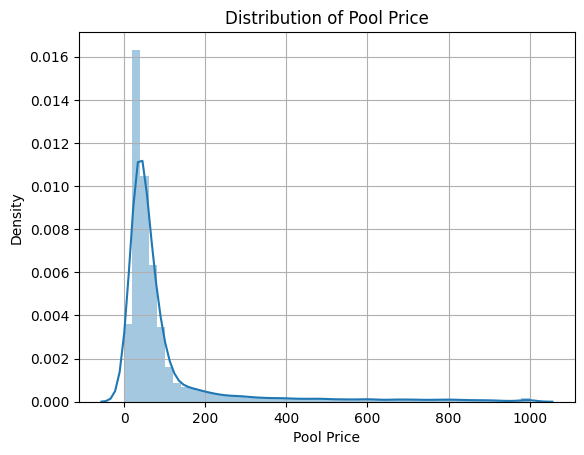

In [10]:
# Create a distribution plot of the 'pool_price' column
sns.distplot(df['pool_price'], hist=True, kde=True)

# Add labels and title
plt.xlabel('Pool Price')
plt.ylabel('Density')
plt.title('Distribution of Pool Price')

# Show the plot
plt.grid()
plt.show()

In [11]:
# data filter to remove outliers
# df = df[df['pool_price'] <=200]

#### Train-Test split

In [12]:
df.head()

,datetime_,forecast_alberta_internal_load,pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2020-01-01 00:00:00,9688.0,30.24,43.49,0.0,2.2,-0.6,-2.7,875.637983,10.0,11.0,7.0,0,2,1,1,1,2020,1,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
1,2020-01-01 01:00:00,9541.0,29.43,43.49,0.0,1.4,1.1,-4.6,778.695505,7.0,11.0,3.0,1,2,1,1,1,2020,1,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
2,2020-01-01 02:00:00,9410.0,29.66,43.49,0.0,2.5,1.3,-7.0,717.339528,8.0,11.0,6.0,2,2,1,1,1,2020,1,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
3,2020-01-01 03:00:00,9328.0,28.19,43.49,0.0,1.4,0.2,-5.2,691.670863,3.0,11.0,0.0,3,2,1,1,1,2020,1,29.66,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9286.0,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
4,2020-01-01 04:00:00,9319.0,31.17,43.49,0.0,-0.3,0.4,-4.1,553.970998,0.0,11.0,4.0,4,2,1,1,1,2020,1,28.19,29.66,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9209.0,9286.0,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0


In [13]:
# remove lag terms except 24 hours lag
# df.drop(columns = [col for col in df.columns if col.startswith('alberta_internal_load_lag') and col!='alberta_internal_load_lag_24'], inplace = True)
# df.drop(columns = [col for col in df.columns if col.startswith('pool_price_lag') and col!='pool_price_lag_24'], inplace = True)

In [14]:
# Convert datetime_ column to datetime type
df['datetime_'] = pd.to_datetime(df['datetime_'])

# Filter data for the first 11 months
train_data = df[df['datetime_'] < '2024-07-01']
test_data = df[df['datetime_'] >= '2024-07-01']

# Define independent variables (features) and target variable
X_train = train_data.drop(columns=['datetime_', 'pool_price'])
y_train = train_data['pool_price']
# Display the shapes of the training data
print(X_train.shape, y_train.shape)

# Define independent variables (features) and target variable
X_test = test_data.drop(columns=['datetime_', 'pool_price'])
y_test = test_data['pool_price']
# Display the shapes of the test data
print(X_test.shape, y_test.shape)

(39444, 65) (39444,)
(4419, 65) (4419,)


In [15]:
#Converting dataframe to numpy
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [16]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
#Reshaping the train and test data to pass into the LSTM layer
X_train = X_train.reshape((X_train.shape[0], 1, int(X_train.shape[1])))
X_test = X_test.reshape((X_test.shape[0], 1, int(X_test.shape[1])))

In [18]:
# Display the shapes of the training data
X_train.shape

(39444, 1, 65)

#### Model Training

In [19]:
#Baseline LSTM model
model = tf.keras.Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation=None))

# Compile the model
model.compile(optimizer='adam', loss='mae')

2025-03-20 16:04:36.308085: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2025-03-20 16:04:36.333129: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2699905000 Hz
2025-03-20 16:04:36.333522: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc110000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-03-20 16:04:36.333579: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-03-20 16:04:36.389590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-20 16:04:36.390127: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x228318b0 initialized for platform CUDA (this does not guarantee that XLA wil

In [20]:
# display architecture of model shape of different layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               99328     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 109,697
Trainable params: 109,697
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=2, validation_split=0.2)

Epoch 1/20


2025-03-20 16:04:41.465461: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-20 16:04:41.748328: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


247/247 - 2s - loss: 76.8701 - val_loss: 45.1362
Epoch 2/20
247/247 - 2s - loss: 41.2269 - val_loss: 40.3121
Epoch 3/20
247/247 - 2s - loss: 33.9010 - val_loss: 38.2680
Epoch 4/20
247/247 - 2s - loss: 32.1515 - val_loss: 37.2931
Epoch 5/20
247/247 - 2s - loss: 31.3297 - val_loss: 36.7107
Epoch 6/20
247/247 - 2s - loss: 30.7836 - val_loss: 36.6132
Epoch 7/20
247/247 - 1s - loss: 30.2678 - val_loss: 36.9434
Epoch 8/20
247/247 - 1s - loss: 29.8595 - val_loss: 36.6351
Epoch 9/20
247/247 - 1s - loss: 29.4774 - val_loss: 36.0058
Epoch 10/20
247/247 - 1s - loss: 29.2241 - val_loss: 36.3716
Epoch 11/20
247/247 - 1s - loss: 28.8310 - val_loss: 36.1253
Epoch 12/20
247/247 - 1s - loss: 28.6511 - val_loss: 36.0170
Epoch 13/20
247/247 - 1s - loss: 28.4082 - val_loss: 36.0626
Epoch 14/20
247/247 - 2s - loss: 28.0630 - val_loss: 35.6192
Epoch 15/20
247/247 - 2s - loss: 27.8652 - val_loss: 36.6604
Epoch 16/20
247/247 - 2s - loss: 27.5567 - val_loss: 36.0792
Epoch 17/20
247/247 - 1s - loss: 27.4965 - v

#### Model Performance Check

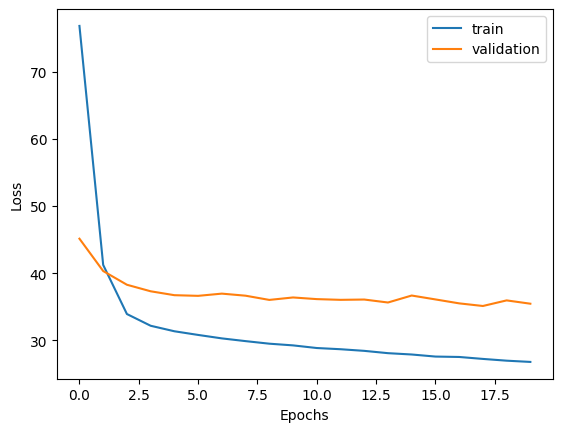

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
y_train_pred = model.predict(X_train)
y_train_pred = y_train_pred.reshape(-1, 1)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print('y_train shape:', y_train.shape)
print(f'Mean Absolute Error on the train set : {mae_train}')
print(f"R² Score train set: {r2_train}")

y_train shape: (39444,)
Mean Absolute Error on the train set : 27.991150498526004
R² Score train set: 0.8227358263858742


In [24]:
y_test_pred = model.predict(X_test)
y_test_pred = y_test_pred.reshape(-1, 1)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print('y_test_pred shape:', y_test_pred.shape)
print(f'Mean Absolute Error on the test set : {mae_test}')
print(f"R² Score test set: {r2_test}")

y_test_pred shape: (4419, 1)
Mean Absolute Error on the test set : 40.22568513136909
R² Score test set: 0.7084419560418289


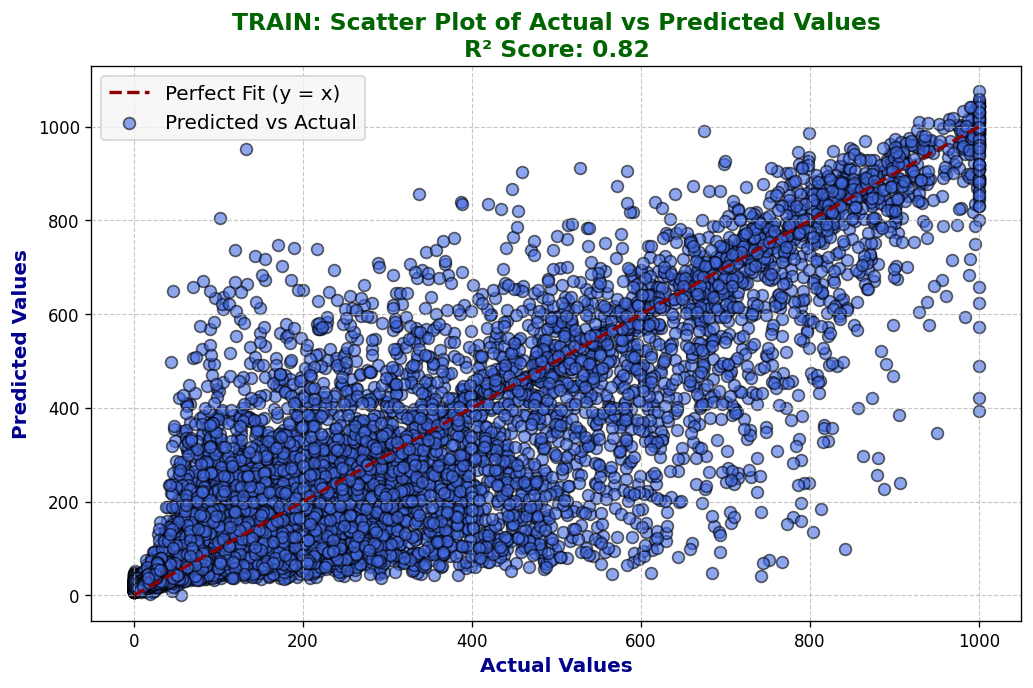

In [25]:
# Create a scatter plot with improved visibility
plt.figure(figsize=(10, 6), dpi=120)  # Higher DPI for sharper visualization

# Scatter plot with larger markers and better color contrast
plt.scatter(y_train, y_train_pred, alpha=0.6, color='royalblue', edgecolor='black', s=50, label='Predicted vs Actual')

# Add reference line (perfect predictions)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 
         color='darkred', linestyle='--', linewidth=2, label='Perfect Fit (y = x)')

# Improve labels and title for better readability
plt.xlabel('Actual Values', fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel('Predicted Values', fontsize=12, fontweight='bold', color='darkblue')
plt.title(f'TRAIN: Scatter Plot of Actual vs Predicted Values\nR² Score: {r2_train:.2f}', 
          fontsize=14, fontweight='bold', color='darkgreen')

# Improve the legend for better clarity
plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='whitesmoke')

# Customize grid for improved visibility
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Enhance tick visibility
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')

# Show the plot
plt.show()


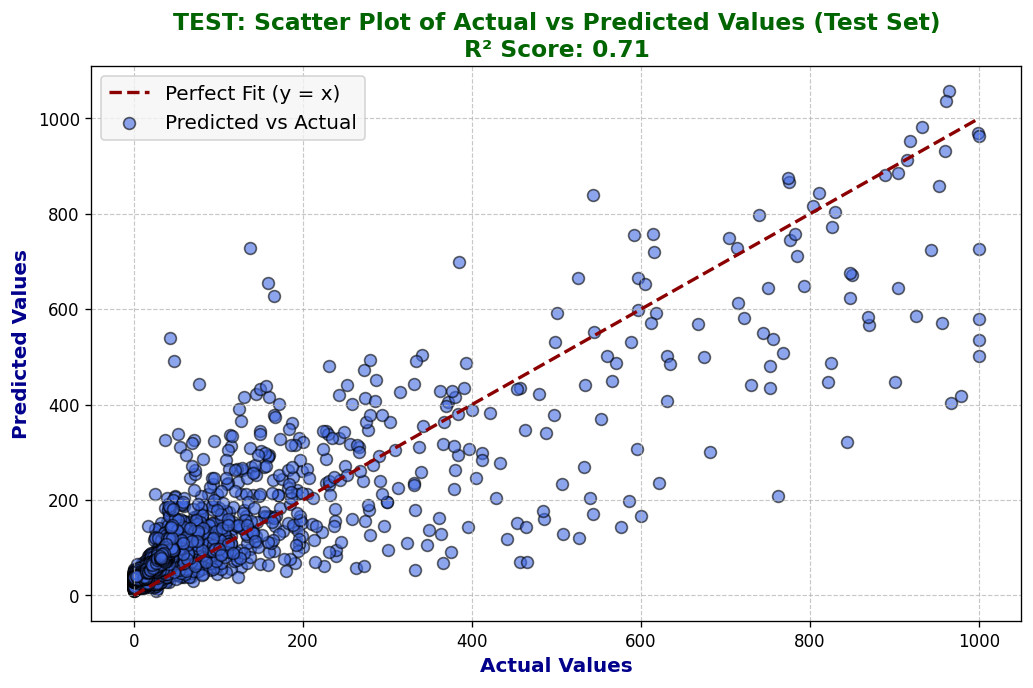

In [26]:
# Create a scatter plot for test data with improved visibility
plt.figure(figsize=(10, 6), dpi=120)  # Higher DPI for sharper visualization

# Scatter plot with larger markers and better color contrast
plt.scatter(y_test, y_test_pred, alpha=0.6, color='royalblue', edgecolor='black', s=50, label='Predicted vs Actual')

# Add reference line (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='darkred', linestyle='--', linewidth=2, label='Perfect Fit (y = x)')

# Improve labels and title for better readability
plt.xlabel('Actual Values', fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel('Predicted Values', fontsize=12, fontweight='bold', color='darkblue')
plt.title(f'TEST: Scatter Plot of Actual vs Predicted Values (Test Set)\nR² Score: {r2_test:.2f}', 
          fontsize=14, fontweight='bold', color='darkgreen')

# Improve the legend for better clarity
plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='whitesmoke')

# Customize grid for improved visibility
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Enhance tick visibility
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')

# Show the plot
plt.show()


In [27]:
# Create a dataframe of the actual and predicted values
results_df = pd.DataFrame({'y_test':y_test, 'y_test_pred':y_test_pred.flatten()})
results_df.head()

,y_test,y_test_pred
0,14.69,30.277470
1,16.23,29.698519
2,15.77,27.053698
3,13.85,26.254139
4,13.58,24.115364


In [28]:
terget_df = results_df[results_df['y_test'] <= 200]

mae = mean_absolute_error(terget_df.y_test, terget_df.y_test_pred)
r2 = r2_score(terget_df.y_test, terget_df.y_test_pred)

print('terget_df shape:', terget_df.shape)
print(f'Mean Absolute Error on the test set : {mae}')
print(f"R² Score test set: {r2}")

terget_df shape: (4203, 2)
Mean Absolute Error on the test set : 34.66420091885429
R² Score test set: -1.2083592759659032


In [29]:
terget_df = results_df[results_df['y_test'] > 200]

mae = mean_absolute_error(terget_df.y_test, terget_df.y_test_pred)
r2 = r2_score(terget_df.y_test, terget_df.y_test_pred)

print('terget_df shape:', terget_df.shape)
print(f'Mean Absolute Error on the test set : {mae}')
print(f"R² Score test set: {r2}")

terget_df shape: (216, 2)
Mean Absolute Error on the test set : 148.44289876655296
R² Score test set: 0.3434053599764778


In [30]:
# run scripts and extract forecasted 24 hours data
# engineer the remaining features
# scale the data
# make predictions

#### Store Model Artifacts

In [63]:
# Save the trained model
def save_model(model, save_path):
    model.save(save_path)
    print(f"Model saved to {save_path}")

save_path = f"/home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/lstm_model_{datetime.now().strftime('%Y%m%d')}.h5"

save_model(model, save_path)

Model saved to /home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/lstm_model_20250320.h5


In [73]:
# Save the scaler
def save_scaler(scaler, save_path):
    joblib.dump(scaler, save_path)
    print(f"Scaler saved to {save_path}")

save_path = f"/home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/scaler_{datetime.now().strftime('%Y%m%d')}.pkl"

save_scaler(scaler, save_path)

Scaler saved to /home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/scaler_20250320.pkl


#### Model Inferencing

In [ ]:
# load inference data
inference_data = pd.read_csv('/home/kevin/Downloads/BESS/Jobs/Inferencing/data/cleaned/merged_df_cleaned.csv')

In [75]:
# Load the saved model
def load_model(save_path):
    model = tf.keras.models.load_model(save_path)
    print(f"Model loaded from {save_path}")
    return model

save_path = f"/home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/lstm_model_{datetime.now().strftime('%Y%m%d')}.h5"

# load trained model
model = load_model(save_path)

Model loaded from /home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/lstm_model_20250320.h5


In [77]:
# Load the scaler
def load_scaler(save_path):
    scaler = joblib.load(save_path)
    print(f"Scaler loaded from {save_path}")
    return scaler

save_path = f"/home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/scaler_{datetime.now().strftime('%Y%m%d')}.pkl"

scaler = load_scaler(save_path)

Scaler loaded from /home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/scaler_20250320.pkl


In [78]:
# data transformation
X_inference = inference_data.drop(columns=['datetime_'])
X_inference = scaler.transform(X_inference)
X_inference = X_inference.reshape((X_inference.shape[0], 1, int(X_inference.shape[1])))

# make predictions
y_inference_pred = model.predict(X_inference)
y_inference_pred = y_inference_pred.reshape(-1, 1)
y_inference_pred

array([[40.84008 ],
       [40.898457],
       [50.041996],
       [55.528152],
       [55.33215 ],
       [52.632683],
       [47.74548 ],
       [43.815575],
       [37.34431 ],
       [35.550556],
       [35.31981 ],
       [35.70145 ],
       [37.394756],
       [40.98639 ],
       [45.748547],
       [47.275097],
       [40.63331 ],
       [30.939926],
       [28.114107],
       [29.324333],
       [30.616375],
       [30.73483 ],
       [30.499538],
       [29.014   ]], dtype=float32)

In [ ]:
# save the predictions
pred_df_new = pd.DataFrame()
pred_df_new['datetime_'] = inference_data['datetime_']
pred_df_new['predicted_pool_price'] = y_inference_pred

# load the existing predictions
try:
    pred_df = pd.read_csv('/home/kevin/Downloads/BESS/Jobs/Inferencing/data/predictions/pred_df.csv')
except:
    pred_df = pd.DataFrame()

# concatenate the new predictions with the existing predictions
pred_df = pd.concat([pred_df, pred_df_new], axis=0, ignore_index=True)
# drop duplicates
pred_df = pred_df.drop_duplicates(subset=['datetime_'], keep='last')
# sort the dataframe by datetime
pred_df = pred_df.sort_values(by='datetime_', ascending=True)
# reset the index
pred_df = pred_df.reset_index(drop=True)
# save the predictions
pred_df.to_csv('/home/kevin/Downloads/BESS/Jobs/Inferencing/data/predictions/pred_df.csv', index=False)

: 